In [1]:
import os
import sys
os.chdir("../../")
#sys.path.append("../../")
# set working directory to the root of the repo

In [2]:
from bert_score import BERTScorer
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests
# define Lmer
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
import seaborn as sns
from itertools import combinations

# Enable automatic conversion between pandas and R dataframes
pandas2ri.activate()
# Import lme4 package
lme4 = importr('lme4')

/home/alice/git-repo/task-extraction/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import BertScore Model Performance Metrics

In [3]:
# import xlsx file from data/bertscore_evaluation/*.xlsx
bertscore_model_performance = pd.read_excel("data/bertscore_evaluation/BERTScore Default Layer Performance on WMT16.xlsx", sheet_name="en")
bertscore_model_performance.head()

# rename the columns
bertscore_model_performance.rename(columns={"WMT16 To-English\nPearson Correlation": "Pearson Correlation"}, inplace=True)

# Experimental Design


1.  `Treatment`: Logical variation between reference and candidate sentences

| Treatment | Description | Example Reference | Example Candidate |
|-----------|-------------|-------------------|------------------|
| Control | Identical sentences | It is raining outside. | It is raining outside. |
| Similar | Reference and candidate have similar meaning | It is raining outside. | It is drizzling now. |
| Opposite | Reference and candidate have the opposite meanings | It is raining outside. | It is sunny outside. |

2. `model_category`: Model category
    - `generic`: All models except scibert
        - number of models: 10 models tried (8 worked)
        - ['albert-xxlarge-v1', 'albert-xxlarge-v2', 'facebook/bart-large-xsum', 'facebook/bart-large', 'microsoft/deberta-base-mnli', 'microsoft/deberta-v2-xlarge', 'facebook/bart-large-cnn', 'microsoft/deberta-v3-base', 'princeton-nlp/sup-simcse-roberta-base', 'microsoft/mpnet-base']
    - `scibert`: scibert models
        - number of models: 7 models tried (3 worked)


In [4]:
# Write 10 sentences ranging from 4-10 words to a list
experiment_list = []
# Control Treatment: 
test_ref = ["It is raining outside.", "I am fine, thanks.", "I am fine, thank you.", "What is the weather like today?", "A very uninteresting sentence.", "A very interesting sentence.", "A very long sentence with many words.", "A very short sentence with few words.", "A sentence with a mix of words.", "The student finished her homework early."]
test_cand = ["It is raining outside.", "I am fine, thanks.", "I am fine, thank you.", "What is the weather like today?", "A very uninteresting sentence.", "A very interesting sentence.", "A very long sentence with many words.", "A very short sentence with few words.", "A sentence with a mix of words.", "The student finished her homework early."]   
print(len(test_ref), len(test_cand))
experiment_list.append({"reference": test_ref, "candidate": test_cand, "type": "Control"})


10 10


In [5]:
# Write 10 sentences ranging from 4-10 words to a list
# Treatment: Small variation but same meaning
test_ref = ["It is raining outside.", "I am fine, thank you.", "I am fine, thank you.", "What is the weather like today?", "A very uninteresting sentence.", "A very interesting sentence.", "A very long sentence with many words.", "A very short sentence with few words.", "He reads books every night before bed.", "The student finished her homework early."]
test_cand = ["It is drizzling now.", "I am fine, thanks.", "I am great, thank you.", "What is today's weather like?", "A very boring sentence.", "A very exciting sentence.", "A lengthy verbose sentence.", "A brief sentence with few words.", "He reads books daily at bedtime.", "The student completed her assignment early."]
print(len(test_ref), len(test_cand))
experiment_list.append({"reference": test_ref, "candidate": test_cand, "type": "Similar"})


10 10


In [6]:
# Treatment: Opposite meaning
test_ref = ["It is raining outside.", "I am fine, thank you.", "I am fine, thank you.", "What is the weather like today?", "A very uninteresting sentence.", "A very interesting sentence.", "A very long sentence with many words.", "A very short sentence with few words.","He reads books every night before bed.", "The student finished her homework early."]
test_cand = ["It is sunny outside.", "I am not fine, thanks.", "I am not fine, thank you.", "What is the weather not like today?", "A very interesting sentence.", "A very uninteresting sentence.", "A very short sentence with few words.", "A lengthy verbose sentence.", "He never reads books before bed", "The student did not finish her homework."]
print(len(test_ref), len(test_cand))
experiment_list.append({"reference": test_ref, "candidate": test_cand, "type": "Opposite"})


10 10


In [7]:
# get subset of the dataframe where the best layer is <11 and sort by rank
bmp_subset = bertscore_model_performance[bertscore_model_performance["Best Layer"] < 11]
bmp_subset = bmp_subset.sort_values(by="Rank").iloc[:10]
print(bmp_subset["Model"].tolist())

# store the top 10 models in a list of dictionaries
models = [{"model": model, 'model_category': "generic"} for model in bmp_subset["Model"].tolist()]
print(models)


['albert-xxlarge-v1', 'albert-xxlarge-v2', 'facebook/bart-large-xsum', 'facebook/bart-large', 'microsoft/deberta-base-mnli', 'microsoft/deberta-v2-xlarge', 'facebook/bart-large-cnn', 'microsoft/deberta-v3-base', 'princeton-nlp/sup-simcse-roberta-base', 'microsoft/mpnet-base']
[{'model': 'albert-xxlarge-v1', 'model_category': 'generic'}, {'model': 'albert-xxlarge-v2', 'model_category': 'generic'}, {'model': 'facebook/bart-large-xsum', 'model_category': 'generic'}, {'model': 'facebook/bart-large', 'model_category': 'generic'}, {'model': 'microsoft/deberta-base-mnli', 'model_category': 'generic'}, {'model': 'microsoft/deberta-v2-xlarge', 'model_category': 'generic'}, {'model': 'facebook/bart-large-cnn', 'model_category': 'generic'}, {'model': 'microsoft/deberta-v3-base', 'model_category': 'generic'}, {'model': 'princeton-nlp/sup-simcse-roberta-base', 'model_category': 'generic'}, {'model': 'microsoft/mpnet-base', 'model_category': 'generic'}]


In [8]:
# get top 10 scibert models
scibert_subset = bertscore_model_performance[bertscore_model_performance["Model"].str.contains("scibert")]
scibert_subset = scibert_subset.sort_values(by="Rank").iloc[:10]
# store the top 10 scibert models in a list of dictionaries
scibert_models = [{"model": model, 'model_category': "scibert"} for model in scibert_subset["Model"].tolist()]
print(scibert_models)

# combine the two lists
models.extend(scibert_models)


[{'model': 'nfliu/scibert_basevocab_uncased', 'model_category': 'scibert'}, {'model': 'scibert-basevocab-uncased', 'model_category': 'scibert'}, {'model': 'allenai/scibert_scivocab_uncased', 'model_category': 'scibert'}, {'model': 'scibert-scivocab-uncased', 'model_category': 'scibert'}, {'model': 'scibert-scivocab-cased', 'model_category': 'scibert'}, {'model': 'allenai/scibert_scivocab_cased', 'model_category': 'scibert'}, {'model': 'scibert-basevocab-cased', 'model_category': 'scibert'}]


In [9]:
# evaluate top models
results = []
not_working = []
counter = 0
for m in models:
    model = m["model"]
    model_category = m["model_category"]
    
    # try changing the tokenizer
    try:
        scorer = BERTScorer(model_type=model, device="cpu")
        working = True
        best_matching_tokenizer = None
    except Exception as e:
        working = False
        not_working.append(model)
        continue

    if not working:
        try: 
            scorer = BERTScorer(model=model, device="cpu", use_fast_tokenizer=False)
            working = True
        except Exception as e:
            working = False
            error_message = str(e)  
            print(f"{error_message}")
            # add to not_working list
            not_working.append(model)
            continue

    if working:
        for experiment_tx in experiment_list:
            treatment = experiment_tx["type"]
            test_ref = experiment_tx["reference"]
            test_cand = experiment_tx["candidate"]

            scores = scorer.score(test_cand, test_ref)
            #print(scores)
            for idx in range(len(scores)):
                output = {"model": model, 
                          "model_category": model_category,
                          "treatment": treatment,  
                          "reference": test_ref[idx], 
                          "candidate": test_cand[idx], 
                          "Precision": float(scores[idx][0]), 
                          "Recall": float(scores[idx][1]), 
                          "F1": float(scores[idx][2])}
                results.append(output)
    if not working:
        print(f"Error with model {model}")
        not_working.append(model)
        continue

    #print(model, float(P), float(R), float(F1))

Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
print(not_working)

['microsoft/deberta-v2-xlarge', 'microsoft/deberta-v3-base', 'scibert-basevocab-uncased', 'scibert-scivocab-uncased', 'scibert-scivocab-cased', 'scibert-basevocab-cased']


In [11]:
results_df = pd.DataFrame(results)
results_df.head()

# print number of unique models for each model_category
unique_models = results_df.groupby("model_category")["model"].unique()
for model_category, models in unique_models.items():
    print(model_category, len(models))
    print(models)



generic 8
['albert-xxlarge-v1' 'albert-xxlarge-v2' 'facebook/bart-large-xsum'
 'facebook/bart-large' 'microsoft/deberta-base-mnli'
 'facebook/bart-large-cnn' 'princeton-nlp/sup-simcse-roberta-base'
 'microsoft/mpnet-base']
scibert 3
['nfliu/scibert_basevocab_uncased' 'allenai/scibert_scivocab_uncased'
 'allenai/scibert_scivocab_cased']


In [12]:
def pymer4_lmer_formula(response: str,   fixed_effects: list, random_effects: list, max_interaction_degree: int = None) -> str:
    """
    Generate formula for pymer4 mixed model including interaction terms and random effects
    
    Args:
        fixed_effects: List of fixed effect factor names
        random_effects: List of random effect factor names
        max_interaction_degree: Maximum degree of interactions for fixed effects
    
    Returns:
        String containing the formula for mixed effects model with interactions
    """
    if max_interaction_degree is None:
        max_interaction_degree = len(fixed_effects)
    
    for degree in range(1, max_interaction_degree + 1): 
        # Generate fixed effects terms with interactions
        fixed_terms = []
        
        # Add main effects
        fixed_terms.extend(fixed_effects)
        
        # Add interaction terms
        for d in range(2, degree + 1):
            for interaction in combinations(fixed_effects, d):
                fixed_terms.append('*'.join(interaction))
    formula = ' + '.join(fixed_terms)
    random_terms = ' + '.join([f'(1|{x})' for x in random_effects])
    # add random effects
    formula = f"{response} ~ {formula} + {random_terms}"
    return formula

# Example usage:
response = 'Precision'
fixed_effects = ['treatment', 'model_category']
random_effects = ['model_category:model']  # Model is treated as a random effect nested within model_category 

# Get formula with all possible interactions
formula_full =  pymer4_lmer_formula(response, fixed_effects, random_effects)
print("Mixed effects formula with all interactions:")
print(formula_full)

# Get formula with only 2-way interactions
formula_2way = pymer4_lmer_formula(response, fixed_effects, random_effects, max_interaction_degree=2)
print("\nMixed effects formula with 2-way interactions:")
print(formula_2way)


Mixed effects formula with all interactions:
Precision ~ treatment + model_category + treatment*model_category + (1|model_category:model)

Mixed effects formula with 2-way interactions:
Precision ~ treatment + model_category + treatment*model_category + (1|model_category:model)


In [13]:
import re
def ols_formula(response: str, fixed_effects: list, max_interaction_degree: int = None):
    if max_interaction_degree is None:
        max_interaction_degree = len(fixed_effects)
    
    for degree in range(1, max_interaction_degree + 1): 
        # Generate fixed effects terms with interactions
        terms = []
        
        # Add main effects
        terms.extend([f"C({x})" for x in fixed_effects])
        
        # Add interaction terms
        for d in range(2, degree + 1):
            for interaction in combinations(fixed_effects, d):
                # add C() around each interaction term
                terms.append('*'.join([f"C({x})" for x in interaction]))
    formula = f"{response} ~ {' + '.join(terms)}"
    return formula

# Example usage
response = 'Precision'
fixed_effects = ['treatment', 'model_category']
ols_formula(response, fixed_effects)


'Precision ~ C(treatment) + C(model_category) + C(treatment)*C(model_category)'

In [14]:
from pymer4.models import Lmer
import numpy as np
def compare_models(data: pd.DataFrame, response: str, fixed_effects: list, random_effects: list = None, max_degree: int = None):
    """
    Compare different models using either OLS (no random effects) or mixed effects (with random effects)
    
    Args:
        data: DataFrame with the data
        response: Name of response variable (e.g., 'Precision')
        fixed_effects: List of fixed effect variables (e.g., ['model_category', 'treatment'])
        random_effects: List of random effect variables (e.g., ['model']) or None
        max_degree: Maximum interaction degree to test
    """
    results = []
    max_degree = max_degree or len(fixed_effects)
    use_mixed = random_effects is not None and len(random_effects) > 0
    
    # Ensure categorical variables are treated as such
    data_copy = data.copy()
    for col in fixed_effects + (random_effects or []):
        data_copy[col] = data_copy[col].astype('category')
    if random_effects is not None:  
        for degree in range(1, max_degree + 1):
            try:
                formula = pymer4_lmer_formula(response, fixed_effects, random_effects, degree)
                
                # Fit mixed model
                print(data_copy.head())
                model = Lmer(formula, data=data_copy)
                fit = model.fit(REML=True)
                print(fit)
                
                results.append({
                    'degree': degree,
                    'formula': formula,
                    'log_likelihood': model.logLike,
                    'num_params': len(model.coefs),
                    'aic': -2 * model.logLike + 2 * len(model.coefs),
                    'bic': -2 * model.logLike + len(model.coefs) * np.log(len(data_copy)),
                    'model': model
                })
            except Exception as e:
                print(f"Error fitting model with degree {degree}: {str(e)}")
                continue
                
    elif random_effects is None:
        for degree in range(1, max_degree + 1):
            try:        
                # For OLS, use C()
                # for interaction terms, use C(factor1)*C(factor2)
                formula = ols_formula(response, fixed_effects, degree)
                
                # Fit OLS model
                model = sm.OLS.from_formula(formula, data=data_copy).fit()
                
                results.append({
                    'degree': degree,
                    'formula': formula,
                    'log_likelihood': model.llf,
                    'num_params': len(model.params),
                    'r2': model.rsquared,
                    'adj_r2': model.rsquared_adj,
                    'aic': model.aic,
                    'bic': model.bic,
                    'model': model
                })
            except Exception as e:
                print(f"Error fitting model with degree {degree}: {str(e)}")
                continue
    
    return pd.DataFrame(results)

# Example usage with random effects:
mixed_comparison = compare_models(
    data=results_df,
    response='Precision',
    fixed_effects=['model_category', 'treatment'],
    random_effects=['model']
)
# get the formula with the lowest AIC
best_model = mixed_comparison.iloc[mixed_comparison['aic'].idxmin()]
print(f"Best model: {best_model['formula']}")

               model model_category treatment               reference  \
0  albert-xxlarge-v1        generic   Control  It is raining outside.   
1  albert-xxlarge-v1        generic   Control      I am fine, thanks.   
2  albert-xxlarge-v1        generic   Control   I am fine, thank you.   
3  albert-xxlarge-v1        generic   Similar  It is raining outside.   
4  albert-xxlarge-v1        generic   Similar   I am fine, thank you.   

                candidate  Precision    Recall        F1  
0  It is raining outside.   1.000000  1.000000  1.000000  
1      I am fine, thanks.   1.000000  1.000000  1.000000  
2   I am fine, thank you.   1.000000  1.000000  1.000000  
3    It is drizzling now.   0.680306  0.879147  0.865562  
4      I am fine, thanks.   0.684408  0.808058  0.865562  
Linear mixed model fit by REML [’lmerMod’]
Formula: Precision~model_category+treatment+(1|model)

Family: gaussian	 Inference: parametric

Number of observations: 99	 Groups: {'model': 11.0}

Log-likelihood:

/home/alice/git-repo/task-extraction/venv/lib/python3.10/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/home/alice/git-repo/task-extraction/venv/lib/python3.10/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


In [15]:
best_models = []
# Find best model with random effects
for response in ['Precision', 'Recall', 'F1']:  
    mixed_comparison = compare_models(
        data=results_df,
        response=response,
        fixed_effects=['model_category', 'treatment'],
        random_effects=['model']
    )
    # get the formula with the lowest AIC
    best_model = mixed_comparison.iloc[mixed_comparison['aic'].idxmin()]
    best_models.append(best_model)

               model model_category treatment               reference  \
0  albert-xxlarge-v1        generic   Control  It is raining outside.   
1  albert-xxlarge-v1        generic   Control      I am fine, thanks.   
2  albert-xxlarge-v1        generic   Control   I am fine, thank you.   
3  albert-xxlarge-v1        generic   Similar  It is raining outside.   
4  albert-xxlarge-v1        generic   Similar   I am fine, thank you.   

                candidate  Precision    Recall        F1  
0  It is raining outside.   1.000000  1.000000  1.000000  
1      I am fine, thanks.   1.000000  1.000000  1.000000  
2   I am fine, thank you.   1.000000  1.000000  1.000000  
3    It is drizzling now.   0.680306  0.879147  0.865562  
4      I am fine, thanks.   0.684408  0.808058  0.865562  
Linear mixed model fit by REML [’lmerMod’]
Formula: Precision~model_category+treatment+(1|model)

Family: gaussian	 Inference: parametric

Number of observations: 99	 Groups: {'model': 11.0}

Log-likelihood:

/home/alice/git-repo/task-extraction/venv/lib/python3.10/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/home/alice/git-repo/task-extraction/venv/lib/python3.10/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: Precision~model_category+treatment+model_category*treatment+(1|model)

Family: gaussian	 Inference: parametric

Number of observations: 99	 Groups: {'model': 11.0}

Log-likelihood: 145.595 	 AIC: -275.191

Random effects:

                 Name    Var    Std
model     (Intercept)  0.002  0.044
Residual               0.002  0.041

No random effect correlations specified

Fixed effects:

                                         Estimate  2.5_ci  97.5_ci     SE  \
(Intercept)                                 1.000   0.965    1.035  0.018   
model_categoryscibert                       0.000  -0.067    0.067  0.034   
treatmentOpposite                          -0.120  -0.143   -0.096  0.012   
treatmentSimilar                           -0.222  -0.245   -0.199  0.012   
model_categoryscibert:treatmentOpposite     0.015  -0.029    0.060  0.023   
model_categoryscibert:treatmentSimilar     -0.022  -0.066    0.023  0.023   

                   

/home/alice/git-repo/task-extraction/venv/lib/python3.10/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/home/alice/git-repo/task-extraction/venv/lib/python3.10/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


Linear mixed model fit by REML [’lmerMod’]
Formula: Recall~model_category+treatment+model_category*treatment+(1|model)

Family: gaussian	 Inference: parametric

Number of observations: 99	 Groups: {'model': 11.0}

Log-likelihood: 180.435 	 AIC: -344.871

Random effects:

                 Name    Var    Std
model     (Intercept)  0.001  0.031
Residual               0.001  0.028

No random effect correlations specified

Fixed effects:

                                         Estimate  2.5_ci  97.5_ci     SE  \
(Intercept)                                 1.000   0.976    1.024  0.012   
model_categoryscibert                      -0.000  -0.046    0.046  0.023   
treatmentOpposite                          -0.175  -0.191   -0.159  0.008   
treatmentSimilar                           -0.074  -0.090   -0.058  0.008   
model_categoryscibert:treatmentOpposite     0.047   0.016    0.078  0.016   
model_categoryscibert:treatmentSimilar     -0.015  -0.045    0.016  0.016   

                      

/home/alice/git-repo/task-extraction/venv/lib/python3.10/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(
/home/alice/git-repo/task-extraction/venv/lib/python3.10/site-packages/pymer4/models/Lmer.py:733: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ran_vars = ran_vars.applymap(


In [16]:
# convert to dataframe
best_models_df = pd.DataFrame(best_models)
best_models_df.head()
# add a column for the response
best_models_df['response'] = best_models_df['formula'].apply(lambda x: x.split(" ~ ")[0])   
# sort by response and aic
best_models_df = best_models_df.sort_values(by=['response', 'aic'])
print(best_models_df.head())
# keep rows with lowest aic by response
best_models_df = best_models_df.groupby('response').first().reset_index()
best_models_df.head()


   degree                                            formula  log_likelihood  \
1       2  F1 ~ model_category + treatment + model_catego...      198.270187   
0       1  Precision ~ model_category + treatment + (1|mo...      150.141923   
0       1    Recall ~ model_category + treatment + (1|model)      179.206233   

   num_params         aic         bic  \
1           6 -384.540374 -368.969655   
0           4 -292.283847 -281.903367   
0           4 -350.412465 -340.031986   

                                               model   response  
1  pymer4.models.Lmer(fitted = True, formula = F1...         F1  
0  pymer4.models.Lmer(fitted = True, formula = Pr...  Precision  
0  pymer4.models.Lmer(fitted = True, formula = Re...     Recall  


,response,degree,formula,log_likelihood,num_params,aic,bic,model
0,F1,2,F1 ~ model_category + treatment + model_catego...,198.270187,6,-384.540374,-368.969655,"pymer4.models.Lmer(fitted = True, formula = F1..."
1,Precision,1,Precision ~ model_category + treatment + (1|mo...,150.141923,4,-292.283847,-281.903367,"pymer4.models.Lmer(fitted = True, formula = Pr..."
2,Recall,1,Recall ~ model_category + treatment + (1|model),179.206233,4,-350.412465,-340.031986,"pymer4.models.Lmer(fitted = True, formula = Re..."


In [17]:
for idx, row in best_models_df.iterrows():
    print(row['formula'])
    # report significant terms
    df =pd.DataFrame(row['model'].summary())
    # Return the rows where the p-value is significant
    significant_terms = df[df['P-val'] <0.05]
    print(significant_terms)



F1 ~ model_category + treatment + model_category*treatment + (1|model)
Linear mixed model fit by REML [’lmerMod’]
Formula: F1~model_category+treatment+model_category*treatment+(1|model)

Family: gaussian	 Inference: parametric

Number of observations: 99	 Groups: {'model': 11.0}

Log-likelihood: 198.270 	 AIC: -380.540

Random effects:

                 Name    Var    Std
model     (Intercept)  0.001  0.023
Residual               0.001  0.024

No random effect correlations specified

Fixed effects:

                                         Estimate  2.5_ci  97.5_ci     SE  \
(Intercept)                                 1.000   0.981    1.019  0.009   
treatmentOpposite                          -0.123  -0.137   -0.110  0.007   
treatmentSimilar                           -0.101  -0.114   -0.087  0.007   
model_categoryscibert:treatmentOpposite     0.079   0.054    0.105  0.013   
model_categoryscibert:treatmentSimilar      0.056   0.030    0.082  0.013   

                                

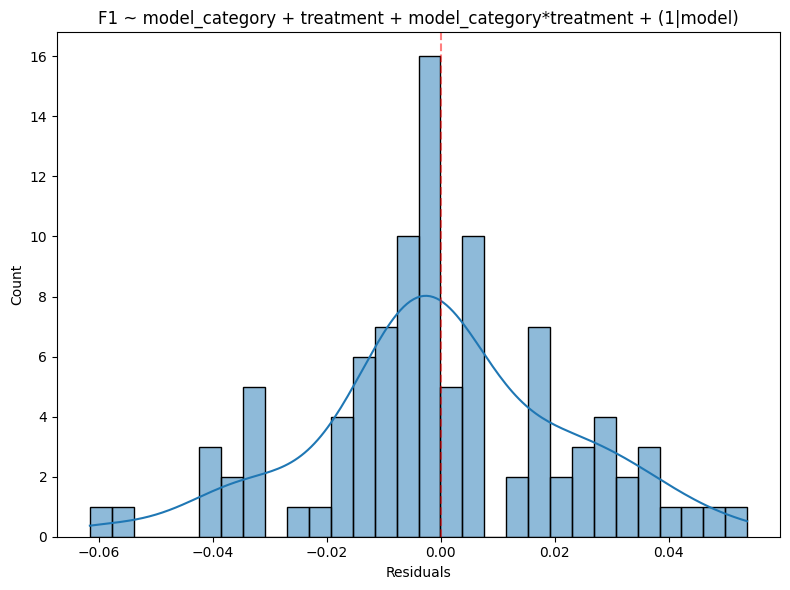

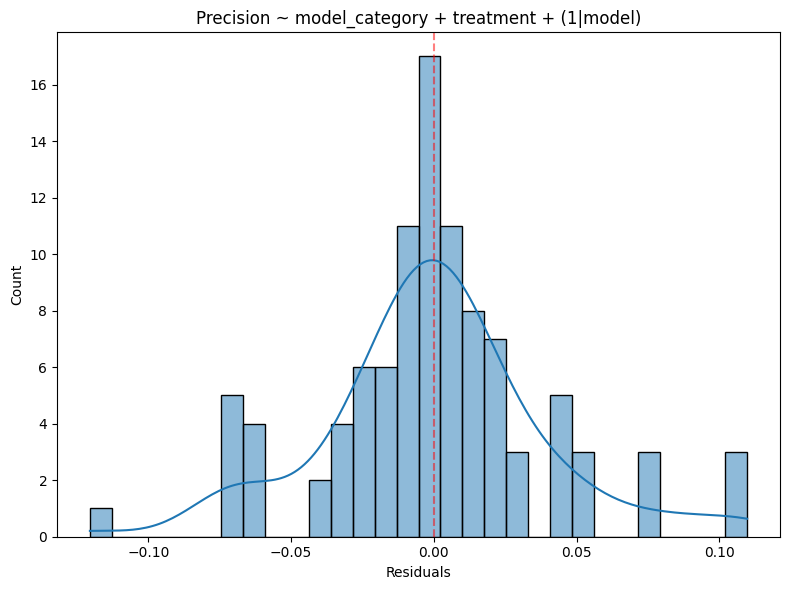

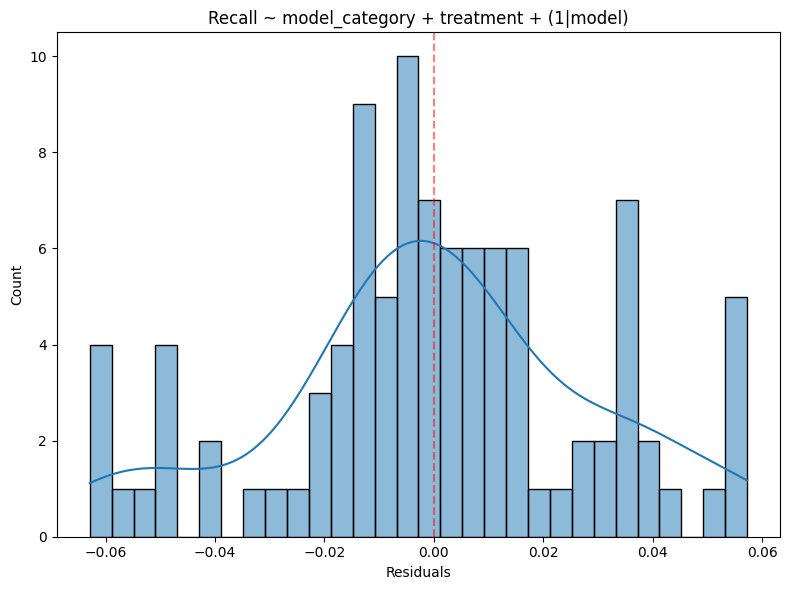

In [18]:
def plot_lmer_residuals_hist(model, bins=30, title: str = None):
    """
    Create histogram of residuals for a fitted Lmer model
    
    Args:
        model: Fitted Lmer model
        bins: Number of bins for histogram (default=30)
    """
    # Get residuals from model
    residuals = model.residuals
    
    # Create histogram
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot histogram with density curve
    sns.histplot(residuals, kde=True, bins=bins, ax=ax)
    
    # Add vertical line at x=0
    ax.axvline(x=0, color='r', linestyle='--', alpha=0.5)
    ax.set_xlabel('Residuals')
    ax.set_ylabel('Count')
    if title is not None:
        ax.set_title(title)
    
    plt.tight_layout()
    plt.show()

# Usage example:
for idx, row in best_models_df.iterrows():
    title = f"{row['formula']}"
    plot_lmer_residuals_hist(row['model'], title=title)

In [19]:
best_models_df

,response,degree,formula,log_likelihood,num_params,aic,bic,model
0,F1,2,F1 ~ model_category + treatment + model_catego...,198.270187,6,-384.540374,-368.969655,"pymer4.models.Lmer(fitted = True, formula = F1..."
1,Precision,1,Precision ~ model_category + treatment + (1|mo...,150.141923,4,-292.283847,-281.903367,"pymer4.models.Lmer(fitted = True, formula = Pr..."
2,Recall,1,Recall ~ model_category + treatment + (1|model),179.206233,4,-350.412465,-340.031986,"pymer4.models.Lmer(fitted = True, formula = Re..."


In [27]:
for idx, row in best_models_df.iterrows():
    print(f"Formula: {row['formula']}")
    print(f"AIC: {row['aic']}")
    print(f"BIC: {row['bic']}")
    print(f"Log likelihood: {row['log_likelihood']}")
    print(f"Num params: {row['num_params']}")
    print(f"{row['model'].summary()}")
    print("\n")


Formula: F1 ~ model_category + treatment + model_category*treatment + (1|model)
AIC: -384.5403742225702
BIC: -368.9696551217627
Log likelihood: 198.2701871112851
Num params: 6
Linear mixed model fit by REML [’lmerMod’]
Formula: F1~model_category+treatment+model_category*treatment+(1|model)

Family: gaussian	 Inference: parametric

Number of observations: 99	 Groups: {'model': 11.0}

Log-likelihood: 198.270 	 AIC: -380.540

Random effects:

                 Name    Var    Std
model     (Intercept)  0.001  0.023
Residual               0.001  0.024

No random effect correlations specified

Fixed effects:

                                         Estimate  2.5_ci  97.5_ci     SE  \
(Intercept)                                 1.000   0.981    1.019  0.009   
model_categoryscibert                       0.000  -0.035    0.035  0.018   
treatmentOpposite                          -0.123  -0.137   -0.110  0.007   
treatmentSimilar                           -0.101  -0.114   -0.087  0.007   
model

`F1~model_category+treatment+model_category*treatment+(1|model)`

| Term | Estimate | P-val |
|------|----------|-------|
| (Intercept) | 1.000 | 0.000 |
| model_categoryscibert | 0.000 | 1.000 |
| treatmentOpposite | -0.123 | 0.000 |
| treatmentSimilar | -0.101 | 0.000 |
| model_categoryscibert:treatmentOpposite | 0.079 | 0.000 |
| model_categoryscibert:treatmentSimilar | 0.056 | 0.000 |

`Precision~model_category+treatment+(1|model)`
| Term | Estimate | P-val |
|------|----------|-------|
| (Intercept) | 1.001 | 0.000 |
| model_categoryscibert | -0.002 | 0.946 |
| treatmentOpposite | -0.116 | 0.000 |
| treatmentSimilar | -0.228 | 0.000 |

`Recall~model_category+treatment+(1|model)`
| Term | Estimate | P-val |
|------|----------|-------|
| (Intercept) | 0.997 | 0.000 |
| model_categoryscibert | 0.011 | 0.632 |
| treatmentOpposite | -0.163 | 0.000 |
| treatmentSimilar | -0.078 | 0.000 |

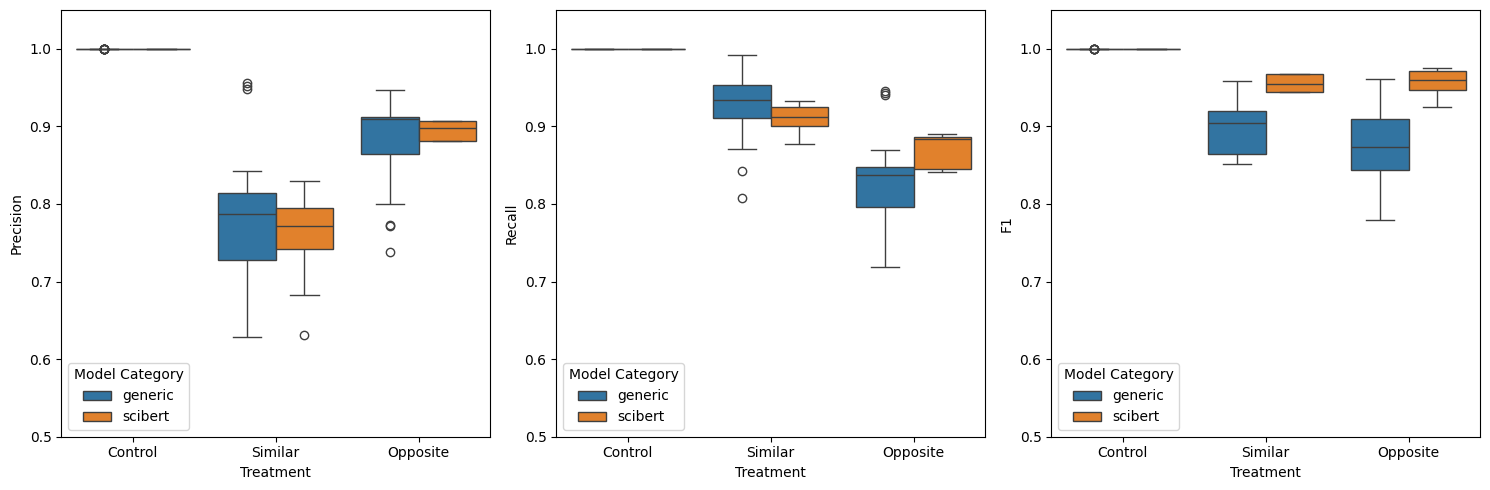

In [21]:
# plot results grouped by treatment and model category
# color by model category
def plot_metrics_by_treatment_colored_by_model_category(data: pd.DataFrame, metrics: list[str] = ['Precision', 'Recall', 'F1']):
    fig, axes = plt.subplots(1, len(metrics), figsize=(15, 5))
    y_min = 0.5
    y_max = 1.05    
    for i, metric in enumerate(metrics):    
        sns.boxplot(x='treatment', y=f"{metric}", data=data, ax=axes[i], hue='model_category')
        axes[i].set_xlabel("Treatment")
        axes[i].set_ylim(y_min, y_max)
        # Position legend in the bottom left corner
        axes[i].legend(title='Model Category', loc='lower left')
    plt.tight_layout()
    plt.show()  

plot_metrics_by_treatment_colored_by_model_category(results_df)   



# Supplement

In [22]:
from itertools import combinations

def generate_interaction_formula(factors: list[str], max_degree: int = 2) -> str:
    """
    Generate a formula string with n-way interactions
    
    Args:
        factors: List of factor names
        max_degree: Maximum interaction degree (defaults to len(factors))
    
    Returns:
        Formula string with main effects and interactions
    """
    if max_degree is None:
        max_degree = len(factors)
    
    # Generate terms for each degree of interaction
    terms = []
    
    # Add terms for each degree (1 = main effects, 2 = 2-way interactions, etc.)
    for degree in range(1, max_degree + 1):
        # Get all combinations of factors for this degree
        factor_combinations = combinations(factors, degree)
        
        # Create interaction terms
        for combo in factor_combinations:
            if degree == 1:
                # Main effect
                terms.append(f'C({combo[0]})')
            else:
                # Interaction effect
                terms.append(':'.join(f'C({f})' for f in combo))
    
    # Join all terms with ' + '
    return ' + '.join(terms)

# Use in your ANOVA function:
def anova_test_with_correction(df: pd.DataFrame, 
                             y_metrics: list[str] = ['Precision', 'Recall', 'F1'],
                             x_factors: list[str] = [ 'model_category', 'treatment'],
                             max_interaction_degree: int = None,
                             correction_method: str = 'fdr_bh'):
    """
    Perform ANOVA for multiple metrics with FDR correction
    
    Args:
        df: DataFrame with columns for metrics, treatment, and other factors
        y_metrics: List of metrics to analyze
        x_factors: List of factors to analyze
        max_interaction_degree: Maximum degree of interactions to test
        correction_method: Correction method for multiple testing
    """
    all_results = []
    
    # Analyze each metric
    for metric in y_metrics:
        # Generate formula with interactions
        x_str = generate_interaction_formula(x_factors, max_interaction_degree)
        formula = f'{metric} ~ {x_str}'
        
        # Fit model and run ANOVA
        try:
            model = ols(formula, data=df).fit()
            anova = sm.stats.anova_lm(model, typ=2)
            
            # Store results with metric name
            for factor in anova.index:
                all_results.append({
                    'metric': metric,
                    'factor': factor,
                    'p_value': anova.loc[factor, 'PR(>F)'],
                    'F_stat': anova.loc[factor, 'F'],
                })
        except Exception as e:
            print(f"Error analyzing {metric}: {str(e)}")
            continue
    # Convert to DataFrame
    all_results_df = pd.DataFrame(all_results)

    #subset dataframe to only include p_values that are not nan
    all_results_df_subset = all_results_df[all_results_df['p_value'].notna()]
    
    # Apply FDR correction across all tests
    all_results_df_subset['p_value_corrected'] = multipletests(all_results_df_subset['p_value'], method=correction_method)[1]
    

    # * if p_value_corrected is < 0.05
    # ** if p_value_corrected is < 0.01
    # *** if p_value_corrected is < 0.001
    # False if p_value_corrected is not significant
    all_results_df_subset['significance'] = all_results_df_subset['p_value_corrected'].apply(lambda x: '***' if x < 0.001 else '**' if x < 0.01 else '*' if x < 0.05 else False)

    # merge the two dataframes
    all_results_df = pd.merge(all_results_df, all_results_df_subset, on=['metric', 'factor', 'p_value', 'F_stat'], how='left')  
    
    return all_results_df

#Example:
results_df = pd.DataFrame(results)

#print(results_df.head())
anova_results = anova_test_with_correction(results_df)

#print the significant results
for idx, row in anova_results.iterrows():
    if row['significance']: 
        print(row['factor'], row['p_value_corrected'], row['significance'])

C(treatment) 1.575518047766381e-26 ***
Residual nan nan
C(treatment) 2.926799738172719e-27 ***
C(model_category):C(treatment) 0.02752459034779182 *
Residual nan nan
C(model_category) 2.5500637557086143e-08 ***
C(treatment) 5.692721511913058e-23 ***
C(model_category):C(treatment) 0.0001177798174473798 ***
Residual nan nan


/tmp/ipykernel_1729/4138411935.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_results_df_subset['p_value_corrected'] = multipletests(all_results_df_subset['p_value'], method=correction_method)[1]
/tmp/ipykernel_1729/4138411935.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_results_df_subset['significance'] = all_results_df_subset['p_value_corrected'].apply(lambda x: '***' if x < 0.001 else '**' if x < 0.01 else '*' if x < 0.05 else False)


In [23]:
anova_results

,metric,factor,p_value,F_stat,p_value_corrected,significance
0,Precision,C(model_category),8.682387e-01,0.027674,8.682387e-01,False
1,Precision,C(treatment),3.501151e-27,125.843399,1.575518e-26,***
2,Precision,C(model_category):C(treatment),5.194685e-01,0.659583,5.844021e-01,False
3,Precision,Residual,NaN,NaN,NaN,NaN
4,Recall,C(model_category),2.399607e-01,1.398672,3.085209e-01,False
5,Recall,C(treatment),3.252000e-28,134.880043,2.926800e-27,***
6,Recall,C(model_category):C(treatment),1.834973e-02,4.175058,2.752459e-02,*
7,Recall,Residual,NaN,NaN,NaN,NaN
8,F1,C(model_category),1.133362e-08,39.283640,2.550064e-08,***
9,F1,C(treatment),1.897574e-23,96.749740,5.692722e-23,***


/tmp/ipykernel_562763/182657064.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_results_df_subset['p_value_corrected'] = multipletests(all_results_df_subset['p_value'], method=correction_method)[1]
/tmp/ipykernel_562763/182657064.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_results_df_subset['significance'] = all_results_df_subset['p_value_corrected'].apply(lambda x: '***' if x < 0.001 else '**' if x < 0.01 else '*' if x < 0.05 else False)


1
1
0


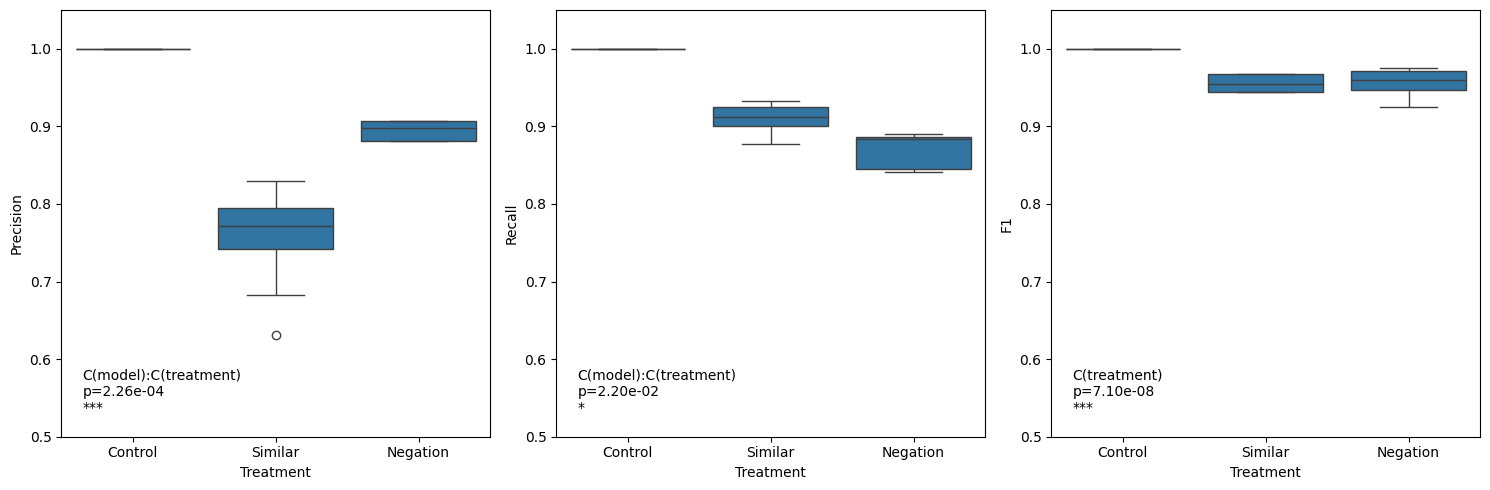

In [62]:
merged = [scibert_results, results]
scibert_results_df = pd.DataFrame(scibert_results)

anova_results = anova_test_with_correction(scibert_results_df)
plot_metrics_by_treatment(scibert_results_df, anova_results)

In [28]:
!jupyter nbconvert --to html scripts/1_evaluation_metrics/1a_evaluate_BERTscore.ipynb

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[NbConvertApp] Converting notebook scripts/1_evaluation_metrics/1a_evaluate_BERTscore.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 5 image(s).
[NbConvertApp] Writing 631543 bytes to scripts/1_evaluation_metrics/1a_evaluate_BERTscore.html
